In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme(style="whitegrid")

# Ejercicio 1
## Descripción:
En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.
## Dataset:
El dataset proporcionado incluye las siguientes variables para cada estudiante:
* Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
* Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
* Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
* Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.
Además, el dataset incluye la variable objetivo:
* Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.
## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.


## Carga de CSV y análisis

In [2]:
df = pd.read_csv("Student_Performance.csv")

In [3]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [10]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

No hay valores nulos

<Figure size 640x480 with 0 Axes>

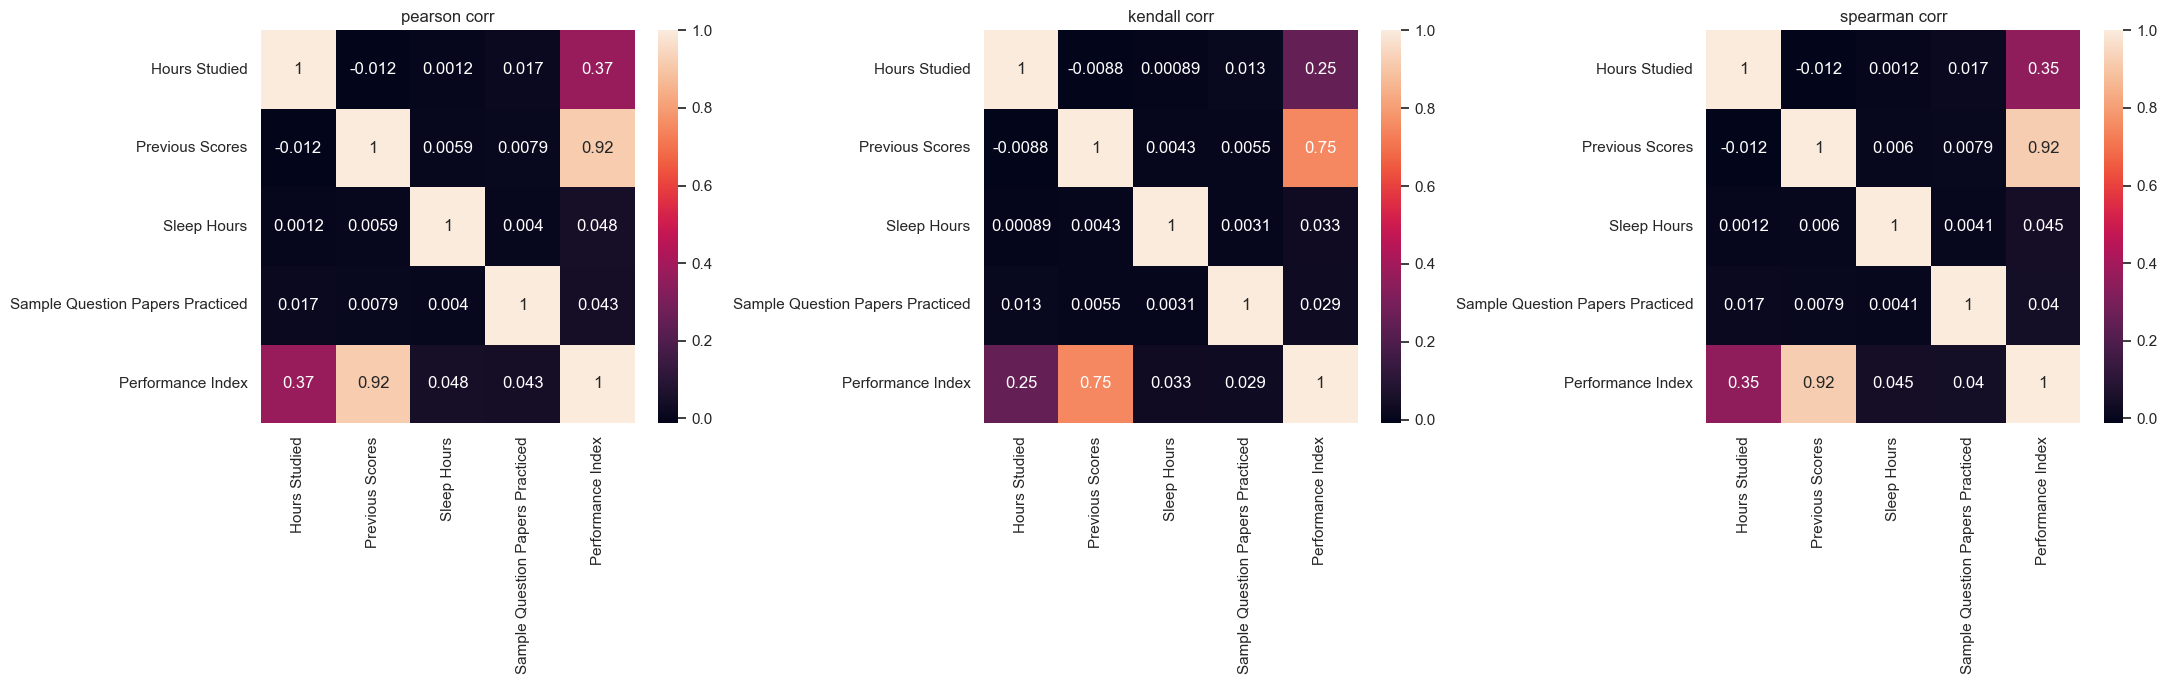

In [45]:
methods = ["pearson", "kendall", "spearman"]
plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
for i, method in enumerate(methods):
    sbn.heatmap(df.corr(numeric_only=True, method=method), ax=axes[i], annot=True)
    axes[i].set_title(f"{method} corr")
plt.tight_layout()
plt.show()

Vemos que las variables descriptivas que más van a servir para realizar la predicción de *Performance Index* son **Hours Studied** y **Previous Scores**

/home/simon/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/simon/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Hours Studied', ylabel='Performance Index'>

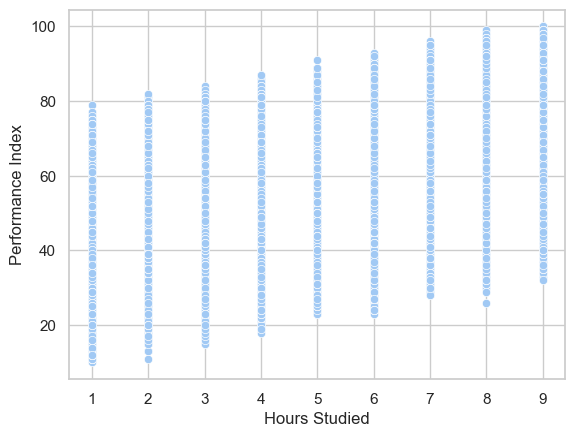

In [50]:
sbn.scatterplot(df, x="Hours Studied", y="Performance Index")

/home/simon/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/simon/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Previous Scores', ylabel='Performance Index'>

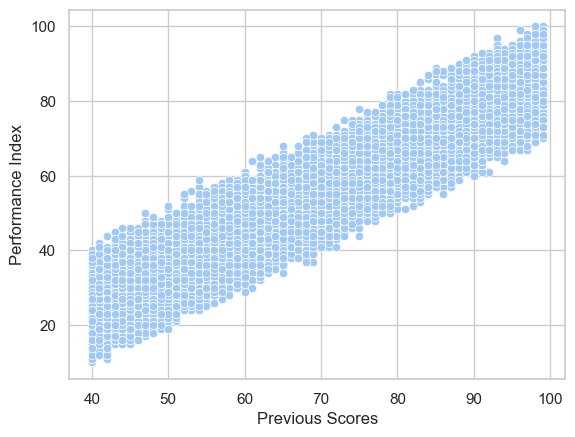

In [51]:
sbn.scatterplot(df, x="Previous Scores", y="Performance Index")

In [91]:
#Convertir variables categóricas a numéricas
df2 = df.copy()
df2["IsExtraAct"] = df["Extracurricular Activities"].apply(lambda x: 1 if x == 'Yes' else 0)
df2.drop(columns="Extracurricular Activities", inplace=True)

In [92]:
df2.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,IsExtraAct
0,7,99,9,1,91.0,1
1,4,82,4,2,65.0,0
2,8,51,7,2,45.0,1
3,5,52,5,2,36.0,1
4,7,75,8,5,66.0,0


## Creación del modelo

In [124]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
import optuna
import os
import random

def set_seeds(seed):  #Setear seed para obtener siempre los mismos resultados
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
set_seeds(72)

In [125]:
## Dividir dataset
#Se elimina la columna target
dfx = df2.drop(columns=["Performance Index"])
dfy = df2["Performance Index"]
X, X_test, y, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=72)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=72)

#### Fine-Tunning
Utilizamos la librería optuna para encontrar los mejores parámetros para el modelo.
Para ello necesitamos una función en donde vamos a definir nuestros posibles parámetros y luego retornamos el RMSE. El propósito es minimizar la función para quedarnos con el modelo que tenga el menor RMSE

In [159]:
def objetivo_regresion(trial: optuna.trial.Trial):
    num_capas = trial.suggest_int("num_capas", 1, 4)
    model = Sequential()
    model.add(Input(shape=(len(X_train.columns), )))
    for i in range(num_capas):
        num_conexiones = trial.suggest_int(f"n_por_capas_{i}", 2, 10)
        model.add(Dense(num_conexiones, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [160]:
estudio_reg = optuna.create_study(direction="minimize")
estudio_reg.optimize(objetivo_regresion, n_trials=10)

[I 2024-04-28 20:19:05,002] A new study created in memory with name: no-name-51b7c7cb-520c-487b-b61a-b34b0bac9cd4


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 2651.4546 - rmse: 51.4923 - val_loss: 1866.1536 - val_rmse: 43.1990
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 1148.0306 - rmse: 33.8826 - val_loss: 562.2375 - val_rmse: 23.7115
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 297.3010 - rmse: 17.2424 - val_loss: 150.6277 - val_rmse: 12.2730
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 128.8154 - rmse: 11.3497 - val_loss: 114.3609 - val_rmse: 10.6940
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 116.8603 - rmse: 10.8102 - val_loss: 110.3738 - val_rmse: 10.5059
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 113.3691 - rmse: 10.6475 - val_loss: 106.9030 - val_rmse: 10.3394
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 109.8523 - rmse: 10.4810 - val_loss: 103.2895 - val_rmse: 10.1631
Epoch 8/10
188/18

[I 2024-04-28 20:19:08,170] Trial 0 finished with value: 9.701948165893555 and parameters: {'num_capas': 1, 'n_por_capas_0': 3}. Best is trial 0 with value: 9.701948165893555.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 488.9025 - rmse: 22.1111 - val_loss: 44.7099 - val_rmse: 6.6865
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 45.9256 - rmse: 6.7768 - val_loss: 42.6091 - val_rmse: 6.5276
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 43.7001 - rmse: 6.6106 - val_loss: 40.7657 - val_rmse: 6.3848
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 41.8874 - rmse: 6.4720 - val_loss: 38.8861 - val_rmse: 6.2359
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 39.9694 - rmse: 6.3221 - val_loss: 37.1117 - val_rmse: 6.0919
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 38.0385 - rmse: 6.1675 - val_loss: 35.3484 - val_rmse: 5.9455
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 36.2334 - rmse: 6.0194 - val_loss: 33.7849 - val_rmse: 5.8125
Epoch 8/10
188/188 [==========================

[I 2024-04-28 20:19:11,728] Trial 1 finished with value: 5.660915374755859 and parameters: {'num_capas': 2, 'n_por_capas_0': 8, 'n_por_capas_1': 10}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 1808.5156 - rmse: 42.5266 - val_loss: 376.7582 - val_rmse: 19.4103
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 139.3191 - rmse: 11.8033 - val_loss: 89.1407 - val_rmse: 9.4414
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 92.6592 - rmse: 9.6260 - val_loss: 85.5672 - val_rmse: 9.2503
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 88.7471 - rmse: 9.4206 - val_loss: 81.2696 - val_rmse: 9.0150
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 84.3849 - rmse: 9.1861 - val_loss: 76.9969 - val_rmse: 8.7748
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 79.9294 - rmse: 8.9403 - val_loss: 72.8345 - val_rmse: 8.5343
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 75.5425 - rmse: 8.6915 - val_loss: 68.4873 - val_rmse: 8.2757
Epoch 8/10
188/188 [=====================

[I 2024-04-28 20:19:15,291] Trial 2 finished with value: 7.699307918548584 and parameters: {'num_capas': 2, 'n_por_capas_0': 6, 'n_por_capas_1': 3}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 4597.3145 - rmse: 67.8035 - val_loss: 2630.1382 - val_rmse: 51.2849
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 1042.8354 - rmse: 32.2930 - val_loss: 167.6984 - val_rmse: 12.9498
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 106.0251 - rmse: 10.2968 - val_loss: 85.6554 - val_rmse: 9.2550
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 86.5156 - rmse: 9.3014 - val_loss: 71.3419 - val_rmse: 8.4464
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 72.5337 - rmse: 8.5167 - val_loss: 61.4085 - val_rmse: 7.8364
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 62.5344 - rmse: 7.9079 - val_loss: 52.9335 - val_rmse: 7.2755
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 53.6558 - rmse: 7.3250 - val_loss: 45.7134 - val_rmse: 6.7612
Epoch 8/10
188/188 [===============

[I 2024-04-28 20:19:18,851] Trial 3 finished with value: 6.043097496032715 and parameters: {'num_capas': 2, 'n_por_capas_0': 7, 'n_por_capas_1': 2}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 720.3200 - rmse: 26.8388 - val_loss: 75.5796 - val_rmse: 8.6937
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 71.6336 - rmse: 8.4637 - val_loss: 66.1057 - val_rmse: 8.1305
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 69.4989 - rmse: 8.3366 - val_loss: 64.8219 - val_rmse: 8.0512
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 68.0452 - rmse: 8.2489 - val_loss: 62.9594 - val_rmse: 7.9347
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 66.1686 - rmse: 8.1344 - val_loss: 61.0446 - val_rmse: 7.8131
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 64.1047 - rmse: 8.0065 - val_loss: 59.0647 - val_rmse: 7.6854
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 61.9086 - rmse: 7.8682 - val_loss: 56.7581 - val_rmse: 7.5338
Epoch 8/10
188/188 [==========================

[I 2024-04-28 20:19:22,858] Trial 4 finished with value: 7.231083869934082 and parameters: {'num_capas': 3, 'n_por_capas_0': 2, 'n_por_capas_1': 2, 'n_por_capas_2': 3}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 1974.0660 - rmse: 44.4305 - val_loss: 912.8472 - val_rmse: 30.2134
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 327.6038 - rmse: 18.0998 - val_loss: 83.8030 - val_rmse: 9.1544
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 80.8908 - rmse: 8.9939 - val_loss: 75.7435 - val_rmse: 8.7031
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 78.9197 - rmse: 8.8837 - val_loss: 73.8214 - val_rmse: 8.5919
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 76.9679 - rmse: 8.7731 - val_loss: 71.8309 - val_rmse: 8.4753
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 74.8515 - rmse: 8.6517 - val_loss: 69.7389 - val_rmse: 8.3510
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 72.6397 - rmse: 8.5229 - val_loss: 67.3656 - val_rmse: 8.2077
Epoch 8/10
188/188 [=====================

[I 2024-04-28 20:19:26,349] Trial 5 finished with value: 7.954775810241699 and parameters: {'num_capas': 2, 'n_por_capas_0': 3, 'n_por_capas_1': 8}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 264.0169 - rmse: 16.2486 - val_loss: 78.7840 - val_rmse: 8.8760
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 81.1959 - rmse: 9.0109 - val_loss: 74.3203 - val_rmse: 8.6209
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 77.4218 - rmse: 8.7990 - val_loss: 70.8661 - val_rmse: 8.4182
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 73.7606 - rmse: 8.5884 - val_loss: 67.1167 - val_rmse: 8.1925
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 69.9826 - rmse: 8.3656 - val_loss: 63.5143 - val_rmse: 7.9696
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 66.2160 - rmse: 8.1373 - val_loss: 60.0648 - val_rmse: 7.7501
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 62.5121 - rmse: 7.9065 - val_loss: 56.4459 - val_rmse: 7.5130
Epoch 8/10
188/188 [==========================

[I 2024-04-28 20:19:29,399] Trial 6 finished with value: 6.97420072555542 and parameters: {'num_capas': 1, 'n_por_capas_0': 5}. Best is trial 1 with value: 5.660915374755859.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 1349.2950 - rmse: 36.7327 - val_loss: 365.6640 - val_rmse: 19.1223
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 140.6621 - rmse: 11.8601 - val_loss: 58.1480 - val_rmse: 7.6255
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 53.3093 - rmse: 7.3013 - val_loss: 42.6146 - val_rmse: 6.5280
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 42.1452 - rmse: 6.4919 - val_loss: 35.8231 - val_rmse: 5.9852
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 36.2712 - rmse: 6.0226 - val_loss: 32.5259 - val_rmse: 5.7031
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 33.0248 - rmse: 5.7467 - val_loss: 30.5185 - val_rmse: 5.5244
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 31.2320 - rmse: 5.5886 - val_loss: 29.4493 - val_rmse: 5.4267
Epoch 8/10
188/188 [=====================

[I 2024-04-28 20:19:32,461] Trial 7 finished with value: 5.307816982269287 and parameters: {'num_capas': 1, 'n_por_capas_0': 7}. Best is trial 7 with value: 5.307816982269287.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 473.9491 - rmse: 21.7704 - val_loss: 85.4375 - val_rmse: 9.2432
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 72.1113 - rmse: 8.4918 - val_loss: 59.5331 - val_rmse: 7.7158
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 54.8248 - rmse: 7.4044 - val_loss: 46.1546 - val_rmse: 6.7937
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 43.7430 - rmse: 6.6138 - val_loss: 37.5889 - val_rmse: 6.1310
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 37.1366 - rmse: 6.0940 - val_loss: 33.2593 - val_rmse: 5.7671
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 33.6378 - rmse: 5.7998 - val_loss: 31.0348 - val_rmse: 5.5709
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 31.8458 - rmse: 5.6432 - val_loss: 29.9199 - val_rmse: 5.4699
Epoch 8/10
188/188 [==========================

[I 2024-04-28 20:19:35,603] Trial 8 finished with value: 5.441960334777832 and parameters: {'num_capas': 1, 'n_por_capas_0': 6}. Best is trial 7 with value: 5.307816982269287.


Epoch 1/10
188/188 [==============================] - 1s 2ms/step - loss: 3117.9790 - rmse: 55.8389 - val_loss: 513.4943 - val_rmse: 22.6604
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 173.3969 - rmse: 13.1680 - val_loss: 68.4098 - val_rmse: 8.2710
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 69.5356 - rmse: 8.3388 - val_loss: 63.9597 - val_rmse: 7.9975
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 67.2029 - rmse: 8.1977 - val_loss: 61.5638 - val_rmse: 7.8463
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 64.6716 - rmse: 8.0419 - val_loss: 59.0357 - val_rmse: 7.6835
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 62.0055 - rmse: 7.8744 - val_loss: 56.5174 - val_rmse: 7.5178
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 59.3513 - rmse: 7.7040 - val_loss: 54.0354 - val_rmse: 7.3509
Epoch 8/10
188/188 [=====================

[I 2024-04-28 20:19:38,670] Trial 9 finished with value: 7.027524948120117 and parameters: {'num_capas': 1, 'n_por_capas_0': 9}. Best is trial 7 with value: 5.307816982269287.


In [161]:
estudio_reg.best_params

{'num_capas': 1, 'n_por_capas_0': 7}

In [162]:
estudio_reg.best_value

5.307816982269287

Utilizando **optuna** logramos un fine-tunning del modelo y obtuvimos los siguientes resultados:

**MODELO:**
* Número de capas: 1
* Neuronas capa 1: 7
  
**Mínimo RMSE:** 5.31

#### Creación del modelo

In [163]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns), )))
model.add(Dense(units=7, activation="relu"))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])

In [164]:
model.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_269 (Dense)           (None, 7)                 42        
                                                                 
 dense_270 (Dense)           (None, 1)                 8         
                                                                 
Total params: 50 (200.00 Byte)
Trainable params: 50 (200.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [166]:
model_history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/10
188/188 [==============================] - 0s 1ms/step - loss: 30.9469 - rmse: 5.5630 - val_loss: 29.4404 - val_rmse: 5.4259
Epoch 2/10
188/188 [==============================] - 0s 1ms/step - loss: 30.2474 - rmse: 5.4998 - val_loss: 28.6404 - val_rmse: 5.3517
Epoch 3/10
188/188 [==============================] - 0s 1ms/step - loss: 29.4387 - rmse: 5.4257 - val_loss: 28.0114 - val_rmse: 5.2926
Epoch 4/10
188/188 [==============================] - 0s 1ms/step - loss: 28.8771 - rmse: 5.3737 - val_loss: 27.4416 - val_rmse: 5.2385
Epoch 5/10
188/188 [==============================] - 0s 1ms/step - loss: 28.3429 - rmse: 5.3238 - val_loss: 27.0760 - val_rmse: 5.2035
Epoch 6/10
188/188 [==============================] - 0s 1ms/step - loss: 27.6898 - rmse: 5.2621 - val_loss: 26.4498 - val_rmse: 5.1429
Epoch 7/10
188/188 [==============================] - 0s 1ms/step - loss: 27.1242 - rmse: 5.2081 - val_loss: 25.9896 - val_rmse: 5.0980
Epoch 8/10
188/188 [============================

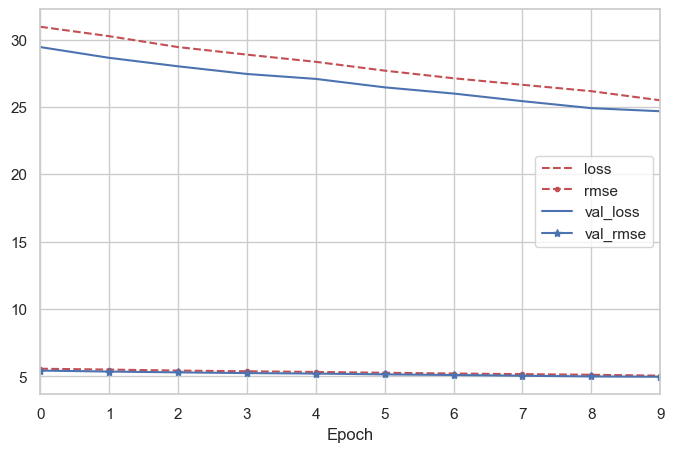

In [171]:
pd.DataFrame(model_history.history).plot(figsize=(8, 5), xlim=[0, 9],  grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

Podemos ver que los valores de función de pérdida son más grandes a los de la pérdida de validación. Tambien vemos que los valores de RMSE, tanto para training como validation no van cambiando a lo largo del tiempo ya que desde la primer epoch tienen valores bajos. No contamos con overfitting

## Explicabilidad del modelo
Utilizando la librería de shap podemos ver qué tanto afectan las variables descriptivas a nuestro modelo

In [173]:
import shap
shap.initjs()

In [175]:
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[20,:])

Vemos que la hipótesis que habíamos realizado al principio en la que indicábamos que **Hours Studied** y **Previous Scores** iban a ser las más importantes al momento de realizar la predicción es verdadera